In [1]:
import networkx as nx
from itertools import combinations
import json
import numpy as np
import random as rd
from collections import defaultdict

%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
def create_simplicial_complex_from_cliques(cliques):
    
    G = nx.Graph()
    triangles_list = set() #will contain list of triangles (2-simplices)
    
    for c in cliques:
        d = len(c)
        
        if d==2:
            i, j = c
            G.add_edge(i, j)
        
        elif d==3:
            #adding the triangle as a sorted tuple (so that we don't get both ijk and jik for example)
            triangles_list.add(tuple(sorted(c)))
            #adding the single links
            for i, j in combinations(c, 2):
                G.add_edge(i, j)
            
        else: #d>3, but I only consider up to dimension 3
            #adding the triangles
            for i, j, k in combinations(c, 3):
                triangles_list.add(tuple(sorted([i,j,k])))

            #adding the single links
            for i, j in combinations(c, 2):
                G.add_edge(i, j)
                
    if nx.is_connected(G)==False:
        print('not connected')
                
    #Creating a dictionary of neighbors
    node_neighbors_dict = {}
    for n in G.nodes():
        node_neighbors_dict[n] = G[n].keys()
        
    #converting the triangle set of tuples into a triangle list of lists
    triangles_list = [list(tri) for tri in triangles_list]

    return node_neighbors_dict, triangles_list


def import_sociopattern_simcomp_SCM(dataset_dir, dataset, n_minutes, thr):
    filename = dataset_dir+'random_'+str(n_minutes)+'_'+str(thr)+'min_cliques_'+dataset+'.json'
    SCM_cliques_list = json.load(open(filename,'r'))
    
    #considering one realization of the SCM
    realization_number = rd.choice(range(len(SCM_cliques_list)))
    cliques = SCM_cliques_list[realization_number] 
    node_neighbors_dict, triangles_list = create_simplicial_complex_from_cliques(cliques)
    
    N = len(node_neighbors_dict.keys())
    avg_k1 = 1.*sum([len(v) for v in node_neighbors_dict.values()])/N
    avg_k2 = 3.*len(triangles_list)/N 
    #ass = nx.degree_assortativity_coefficient(facet_list_to_graph(cliques))

    #print N, avg_k1, avg_k2, "Assortativity %.2f"%ass
    
    return node_neighbors_dict, triangles_list, avg_k1, avg_k2

def get_tri_neighbors_dict(triangles_list):
    tri_neighbors_dict = defaultdict(list)
    for i, j, k in triangles_list:
        tri_neighbors_dict[i].append((j,k))
        tri_neighbors_dict[j].append((i,k))
        tri_neighbors_dict[k].append((i,j))
    return tri_neighbors_dict

In [8]:
def markovChain(beta_A, beta_D_A, mu_A, beta_B, beta_D_B, mu_B, epsilon_A, epsilon_B, node_neighbors_dict, tri_neighbors_dict, NSteps, i0_A, i0_B, i0_AB):
    N = len(node_neighbors_dict)
    
    #initial seeds
    p_A = np.zeros(N)
    p_A[rd.sample(range(N),int(N*i0_A))] = 1
    p_A_new = np.copy(p_A)
    
    p_B = np.zeros(N)
    p_B[rd.sample(range(N),int(N*i0_B))] = 1
    p_B_new = np.copy(p_B)
    
    p_AB = np.zeros(N)
    p_AB[rd.sample(range(N),int(N*i0_AB))] = 1
    p_AB_new = np.copy(p_AB)
    
    q_BA = 1
    q_AB = 1
    q_S = 1
    q_A = 1
    q_B = 1
    
    pATime = [np.mean(p_A)]
    pBTime = [np.mean(p_B)]
    pABTime = [np.mean(p_AB)]
    
    for k in range(0,NSteps):
        for i in range(0,N):
            #updating the infections - simple contagion
            for j in node_neighbors_dict[i]:
                q_BA *= 1-epsilon_B*beta_A*(p_A[j]+p_AB[j])
                q_AB *= 1-epsilon_A*beta_B*(p_B[j]+p_AB[j])
                q_S *= 1-beta_A*(p_A[j]+p_AB[j])-beta_B*(p_B[j]+p_AB[j])+beta_A*beta_B*p_AB[j]*p_AB[j]
                q_A *= 1-beta_A*(p_A[j]+p_AB[j])
                q_B *= 1-beta_B*(p_B[j]+p_AB[j])
                
            #updating the infections - triangle contagion
            for j, k in tri_neighbors_dict[i]:
                q_BA *= 1-epsilon_B*beta_D_A*(p_A[j]+p_AB[j])*(p_A[k]+p_AB[k])
                q_AB *= 1-epsilon_A*beta_D_B*(p_B[j]+p_AB[j])*(p_B[k]+p_AB[k])
                q_S *= 1-beta_D_A*(p_A[j]+p_AB[j])*(p_A[k]+p_AB[k])-beta_D_A*(p_B[j]+p_AB[j])*(p_B[k]+p_AB[k])+beta_D_A*beta_D_B*p_AB[j]*p_AB[j]*p_AB[k]*p_AB[k]
                q_A *= 1-beta_D_A*(p_A[j]+p_AB[j])*(p_A[k]+p_AB[k])
                q_B *= 1-beta_D_B*(p_B[j]+p_AB[j])*(p_B[k]+p_AB[k])
            
            #calculating f_A and f_B
            if ((1-q_A)*(1-0.5*(1-q_B))) == 0.0:
                f_A = 0.
            else:
                f_A=(1-q_A)*(1-0.5*(1-q_B))/((1-q_A)*(1-0.5*(1-q_B))+(1-q_B)*(1-0.5*(1-q_A)))
            if ((1-q_B)*(1-0.5*(1-q_A))) == 0.0:
                f_B = 0.
            else:            
                f_B=(1-q_B)*(1-0.5*(1-q_A))/((1-q_A)*(1-0.5*(1-q_B))+(1-q_B)*(1-0.5*(1-q_A)))
            
            #Updating the vectors
            p_AB_new[i] = p_B[i]*(1-mu_B)*(1-q_BA)+p_A[i]*(1-mu_A)*(1-q_AB)+p_AB[i]*(1-mu_A)*(1-mu_B)
            p_A_new[i] = p_B[i]*mu_B*(1-q_BA)+p_A[i]*(1-mu_A)*q_AB+p_AB[i]*mu_B*(1-mu_A)+(1-p_A[i]-p_B[i]-p_AB[i])*f_A*(1-q_S)
            p_B_new[i] = p_A[i]*mu_B*(1-q_AB)+p_B[i]*(1-mu_B)*q_BA+p_AB[i]*mu_A*(1-mu_B)+(1-p_A[i]-p_B[i]-p_AB[i])*f_B*(1-q_S)
            
            #resetting the parameters
            q_BA = 1
            q_AB = 1
            q_S = 1
            q_A = 1
            q_B = 1
        
        p_A = np.copy(p_A_new)
        p_B = np.copy(p_B_new)
        p_AB = np.copy(p_AB_new)
        
        pATime.append(np.mean(p_A))
        pBTime.append(np.mean(p_B))
        pABTime.append(np.mean(p_AB))
    
    return pATime, pBTime, pABTime    
    

In [9]:
dataset_dir = '/Users/thomasrobiglio/simplicialSad/simplagion_interactive/sociopatterns_thr_data_random/'
dataset = 'Thiers13'
n_minutes = 5 #aggregation time
thr = 0.80 #fraction of removed cliques (0.80: retaining the 20% most weighted)

node_neighbors_dict, triangles_list, avg_k1, avg_k2 = import_sociopattern_simcomp_SCM(dataset_dir, dataset, n_minutes, thr)
tri_neighbors_dict = get_tri_neighbors_dict(triangles_list)

mu_A = 0.05 #rec. prob. A
mu_B = 0.05 #rec. prob. A

lambda1_A = 1.2 #rescaled 1-simplex inf. prob. A
lambdaD_A = 0.8 #desired rescaled 2-simplex inf. prob. A

lambda1_B = 1.2 #rescaled 1-simplex inf. prob. B
lambdaD_B = 0.8 #desired rescaled 2-simplex inf. prob. B

i0_A = 0.4 #initial conditions (% of infectious nodes at t=0) A
i0_B = 0.4 #initial conditions (% of infectious nodes at t=0) B
i0_AB = 0.2 #initial conditions (% of infectious nodes at t=0) AB

beta_A = 1.*(mu_A/avg_k1)*lambda1_A #1-simplex inf. prob. A
beta_D_A = 1.*(mu_A/avg_k2)*lambdaD_A #2-simplex inf. prob. A

beta_B = 1.*(mu_B/avg_k1)*lambda1_B #1-simplex inf. prob. A
beta_D_B = 1.*(mu_B/avg_k2)*lambdaD_B #2-simplex inf. prob. A

epsilon_A = 1.5
epsilon_B = 2.

NSteps = 300

In [ ]:
pt_A, pt_B, pt_AB = markovChain(beta_A, beta_D_A, mu_A, beta_B, beta_D_B, mu_B, epsilon_A, epsilon_B, node_neighbors_dict, tri_neighbors_dict, NSteps, i0_A, i0_B, i0_AB)

Text(0, 0.5, 'density of infected')

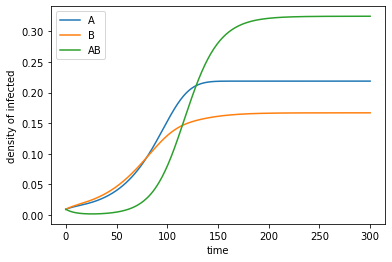

In [6]:
plt.plot(pt_A, label='A')
plt.plot(pt_B, label='B')
plt.plot(pt_AB, label='AB')
plt.legend()
plt.xlabel('time')
plt.ylabel('density of infected')

Text(0, 0.5, 'density of infected')

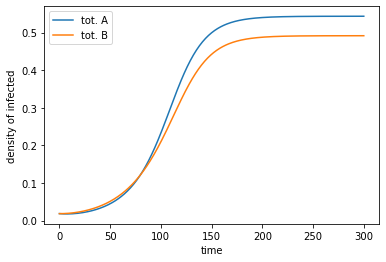

In [10]:
tot_A=[]
tot_B=[]
for i in range(len(pt_A)):
    tot_A.append(pt_A[i]+pt_AB[i])
    tot_B.append(pt_B[i]+pt_AB[i])

plt.plot(tot_A, label='tot. A')
plt.plot(tot_B, label='tot. B')
plt.legend()
plt.xlabel('time')
plt.ylabel('density of infected')